In [1]:
from pyopenms import *
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO

**Load the data**

In [2]:
def extract_core_ID(ID):
    pattern = re.compile(r'sp\|([^|]+)\|')

    # Use the pattern to find the match in the input string
    match = pattern.search(ID)
    
    if match:
        return match.group(0)
    else:
        return ID

In [3]:
top = pd.read_csv("top_down_data/Eclip_1476_MB_ms2_toppic_prsm_single.tsv", sep = "\t", skiprows = 26).sort_values(by = "Spectrum ID")
top[" Protein"] = top["Protein accession"].apply(lambda x: extract_core_ID(x))

In [4]:
fi = pd.read_csv("test_run_FMDFIID.csv")
fi2 = pd.read_csv("top_down_data/out_trunc_diff_depth/window_0_depth_4.csv")

In [5]:
169 / top.shape[0]

0.03425212809079854

In [3]:
def parse_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        for record in SeqIO.parse(fasta_file, 'fasta'):
            sequence_id = record.id
            sequence = str(record.seq)
            sequences[sequence_id] = sequence  
    return sequences
 


In [7]:
eval_all_average_length("top_down_data/uniprot-mg1655-plustrunc.fasta", fi, top, ided)

NameError: name 'eval_all_average_length' is not defined

In [4]:

#this is kind of a weird function
#For each eval_result I also get a list of all not ided specs, I want to measure how much those not ided overlap
def compare_underlap(specs_a, specs_b):
    m = pd.merge(specs_a, specs_b, how = 'inner')
    out_a = (len(specs_a) - len(pd.merge(m, specs_a, how = 'inner'))) / len(specs_a)
    out_b = (len(specs_b) - len(pd.merge(m, specs_b, how = 'inner'))) / len(specs_b)
    return out_a + out_b

def compare_combined(specs_a, specs_b):
    return len(pd.merge(specs_a, specs_b, how='outer'))
    
def eval_result(fi, top):
    fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: ((re.compile(r'[^=]+$')).search(x)).group(0))
    fi[" Protein"] = fi[" Protein"].apply(lambda x: extract_core_ID(x))
    fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: int(x))
    merged = fi.merge(top, on = [" Protein", "Spectrum ID"], how = "inner").drop_duplicates(subset=["Spectrum ID"])
    
    df1_values_not_in_df2 = top[~top['Spectrum ID'].isin(merged['Spectrum ID'])]
    df1_values = top[top['Spectrum ID'].isin(merged['Spectrum ID'])]
    
    return merged.shape[0], df1_values['Spectrum ID'], df1_values_not_in_df2['Spectrum ID']

def get_average_length(sequences, fi):
    c = 0
    for i, r in fi.iterrows():
        c += len(sequences[r[' Protein'].strip()])
    return c / fi.shape[0]

def eval_all_files(folder_path, top_path, fasta_path):
    sequences = parse_fasta(fasta_path)
    
    top = pd.read_csv(top_path, sep = "\t", skiprows = 26)
    top[" Protein"] = top["Protein accession"].apply(lambda x: extract_core_ID(x))
    
    out = pd.DataFrame({"depth":[], "window":[], "ratio_ided":[], "avg_length" : []})
    non_ided_list = []
    ided_list = []
    average_lenght = []
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        pattern = re.compile(r'_(\d+)_.*_(\d+).')
        matches = pattern.search(file_name)
        if matches:
            fi = pd.read_csv(file_path)
            avg_l = get_average_length(sequences, fi)
            ratio, ided, non_ided = eval_result(fi, top)
            ratio = ratio / top.shape[0]
            
            out_concat = pd.DataFrame({"depth" : [matches.group(2)], "window": [matches.group(1)], "ratio_ided": [ratio], "avg_length" : [avg_l] })
            out = pd.concat([out, out_concat], ignore_index = True)
            non_ided_list.append(((int(matches.group(2)), int(matches.group(1))), non_ided))
            ided_list.append(((int(matches.group(2)), int(matches.group(1))), ided))
            
    return out, ided_list, non_ided_list


def eval_average_length_id(fasta_file_path, top, correct_ided):
    pattern = re.compile(r'_([0-9]+)_([0-9]+)')
    sequences = parse_fasta(fasta_file_path)
    
    average_ided_coutner = 0
    for cid in correct_ided:
        protein = (top[top['Spectrum ID'] == cid])
        for i, p in protein.iterrows():   
            average_ided_coutner += (p['Last residue'] - p['First residue'])
    average_ided = average_ided_coutner / len(correct_ided)
    return  average_ided

def eval_all_average_length_id(fasta_file_path, top, ideds):
    aided_list = []
    for i in range(len(ideds)):
        aided = eval_average_length_id(fasta_file_path, top, ideds[i][1])
        aided_list.append(aided)
    return aided_list

In [5]:
fi_vs_top, ided, not_ided = eval_all_files("top_down_data/out_trunc_diff_depth", "top_down_data/Eclip_1476_MB_ms2_toppic_prsm_single.tsv", "top_down_data/uniprot-mg1655-plustrunc.fasta")

In [6]:
fi2_vs_top, ided2, not_ided2 = eval_all_files("top_down_data/out_trunc_diff_depth_fixedprec", "top_down_data/Eclip_1476_MB_ms2_toppic_prsm_single.tsv", "top_down_data/uniprot-mg1655-plustrunc.fasta")

In [11]:
fi_vs_top['avg_length_ided'] = eval_all_average_length_id("top_down_data/uniprot-mg1655-plustrunc.fasta", top, ided)

In [7]:
ided.sort()
matrix = []
for i1 in ided:
    row = []
    for i2 in ided:
        row.append(compare_combined(i1[1], i2[1]))
    matrix.append(row)


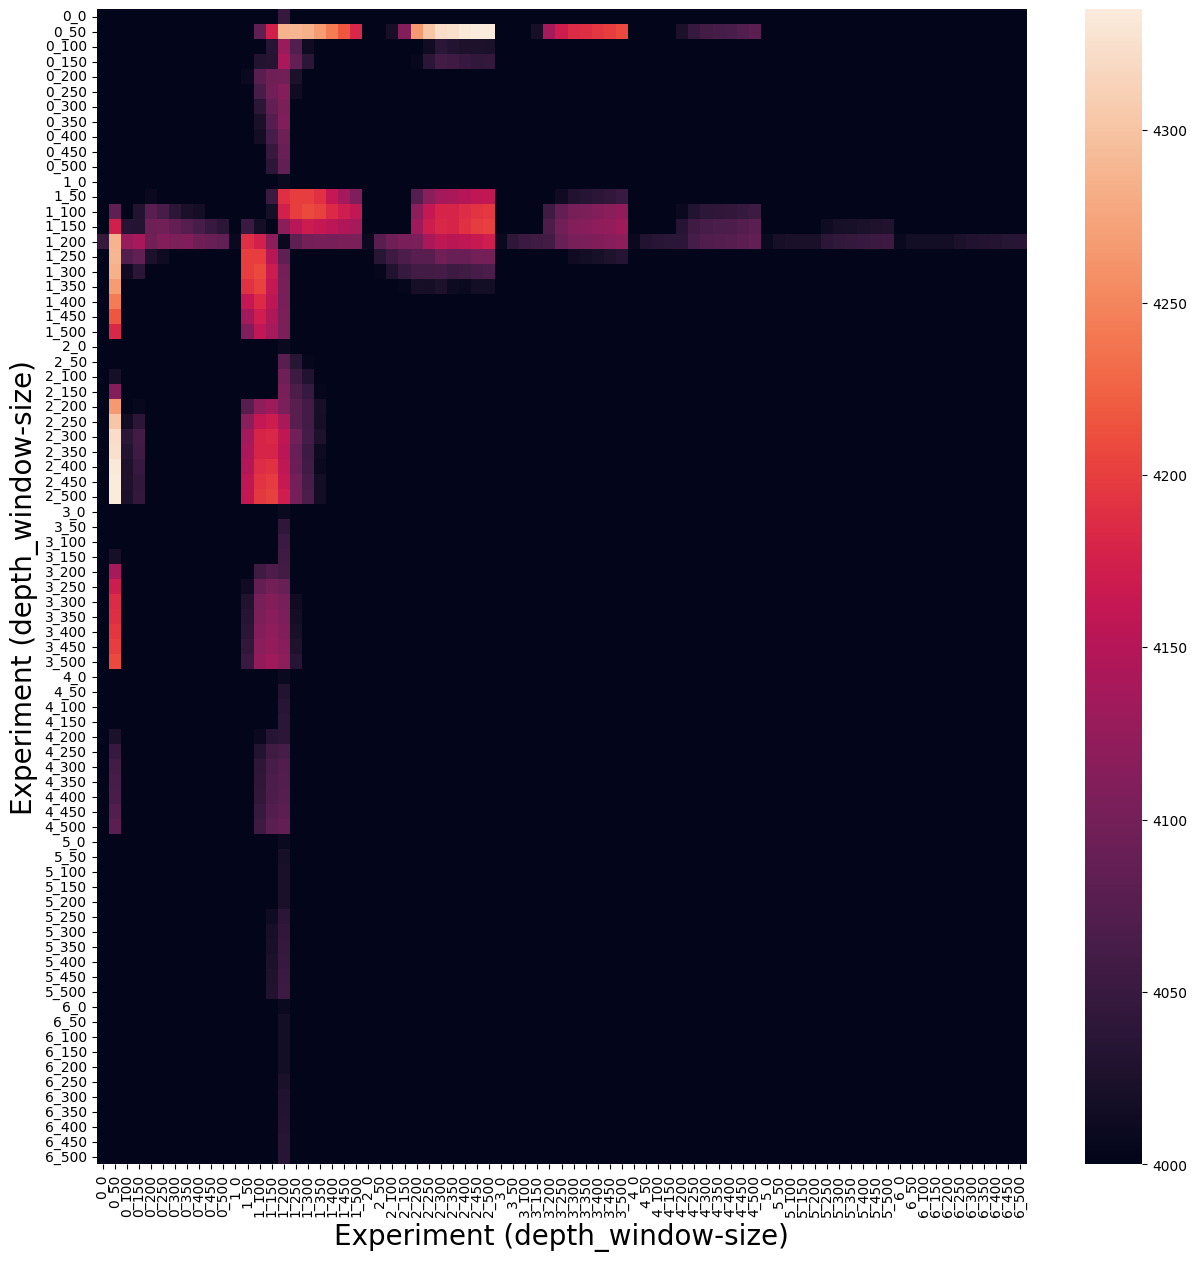

In [15]:
labels = [str(x[0][0]) + "_" + str(x[0][1]) for x in ided]
plt.figure(figsize=(15,15))
sns.heatmap(matrix, vmin = 4000, xticklabels = labels, yticklabels=labels)
plt.xlabel("Experiment (depth_window-size)", size = 20)
plt.ylabel("Experiment (depth_window-size)", size = 20)
plt.savefig("heatmap_MDFIID_combinations.png",  bbox_inches = 'tight', dpi = 500)

In [12]:
ided2.sort()
matrix2 = []
for i1 in ided2:
    row = []
    for i2 in ided2:
        row.append(compare_combined(i1[1], i2[1]))
    matrix2.append(row)


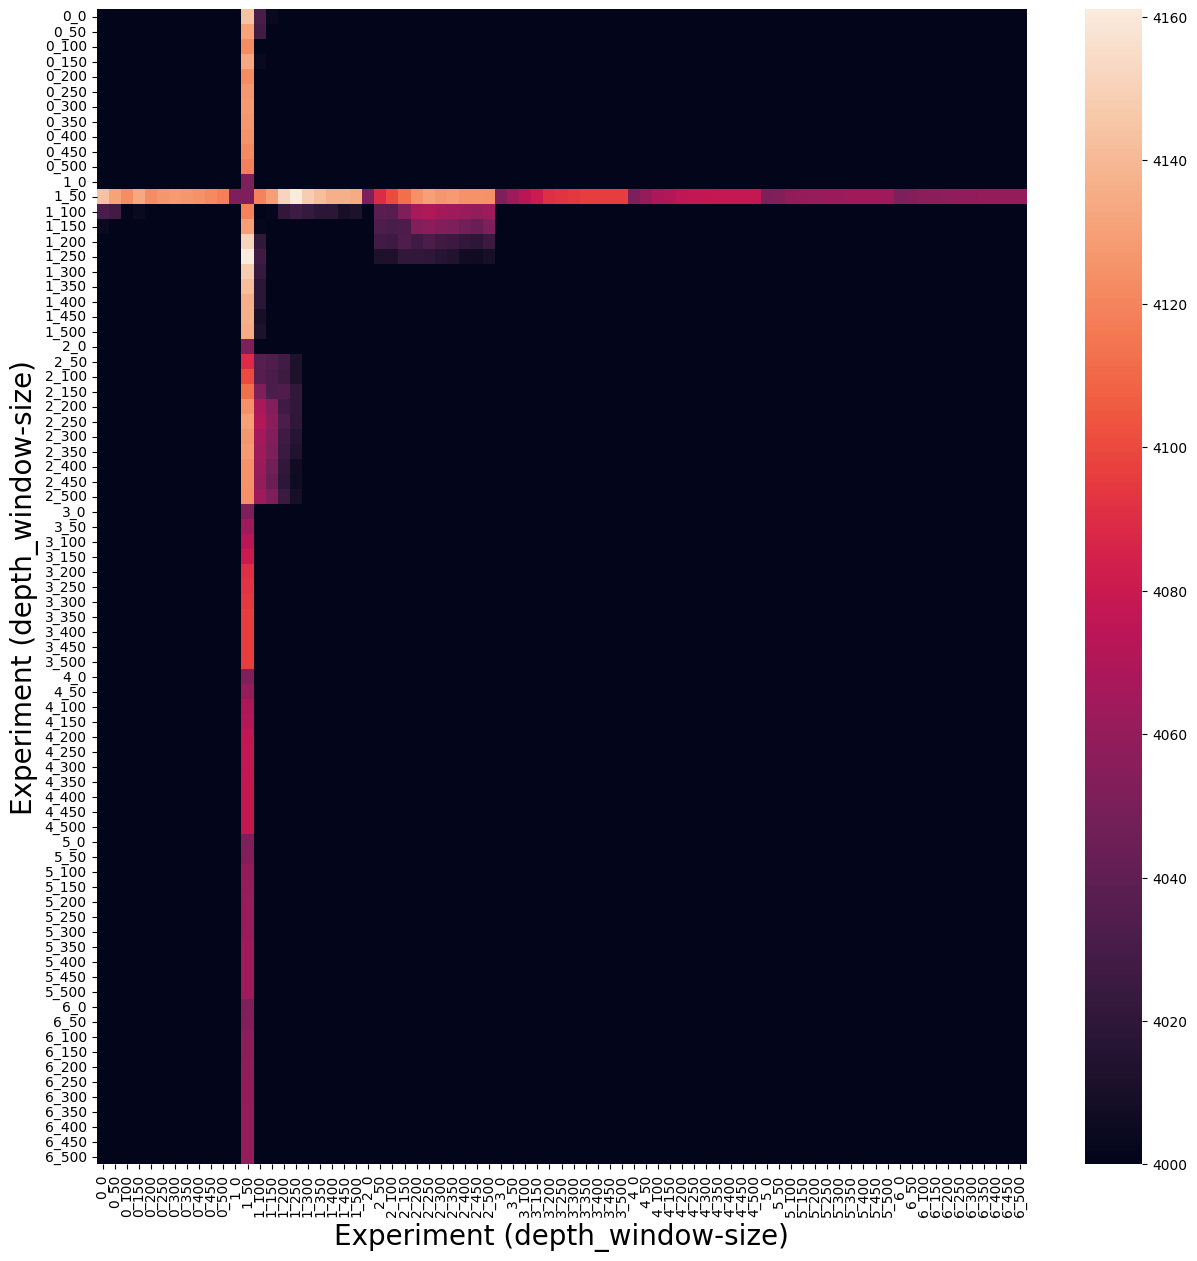

In [14]:
labels = [str(x[0][0]) + "_" + str(x[0][1]) for x in ided2]
plt.figure(figsize=(15,15))
sns.heatmap(matrix2, vmin = 4000, xticklabels = labels, yticklabels=labels)
plt.xlabel("Experiment (depth_window-size)", size = 20)
plt.ylabel("Experiment (depth_window-size)", size = 20)
plt.savefig("heatmap_MDFIID_combinations_fixed.png",  bbox_inches = 'tight', dpi = 500)

In [8]:
fi_vs_top["window"] = fi_vs_top["window"].apply(int)
fi2_vs_top["window"] = fi2_vs_top["window"].apply(int)
fi_vs_top.sort_values(by = "ratio_ided")
fi2_vs_top.sort_values(by = "ratio_ided")

,depth,window,ratio_ided,avg_length
6,6,0,0.001216,60.529412
5,5,0,0.001621,70.923077
4,4,0,0.002837,79.139535
3,3,0,0.004864,70.232558
2,2,0,0.008918,99.884932
...,...,...,...,...
29,1,250,0.754560,198.498046
22,1,200,0.767531,198.017815
15,1,150,0.782529,197.152445
8,1,100,0.791650,196.793572


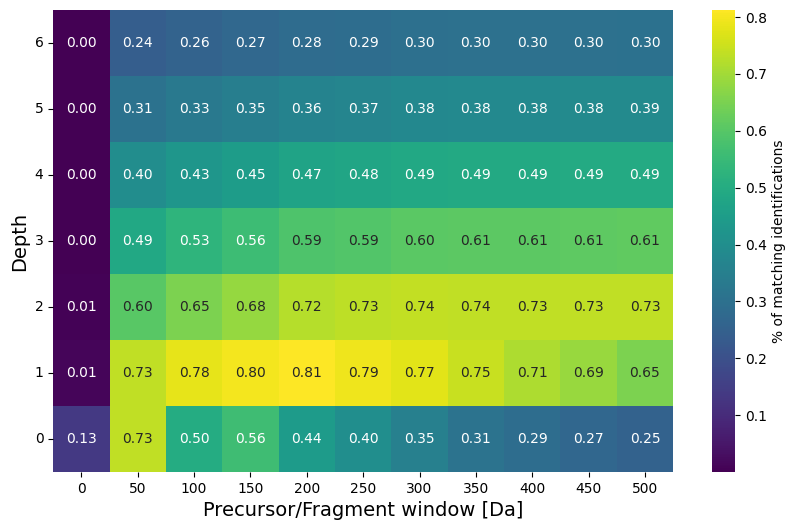

In [9]:
heatmap_data = fi_vs_top.pivot('depth', 'window', 'ratio_ided')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': '% of matching identifications'})

plt.yticks(rotation=0)
plt.gca().invert_yaxis()
plt.title('')
plt.ylabel("Depth", size = 14)
plt.xlabel("Precursor/Fragment window [Da]", size = 14)
plt.savefig("MDFIID_vs_Toppic_truncationunaware.png", bbox_inches = 'tight', dpi = 500)

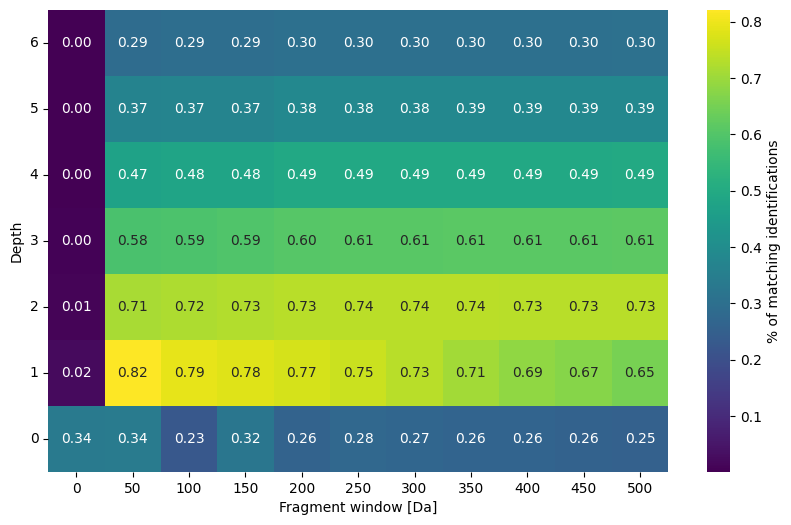

In [10]:
heatmap_data2 = fi2_vs_top.pivot('depth', 'window', 'ratio_ided')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data2, annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': '% of matching identifications'})

plt.yticks(rotation=0)
plt.gca().invert_yaxis()
plt.title('')
plt.ylabel("Depth")
plt.xlabel("Fragment window [Da]")
plt.savefig("MDFIID_vs_Toppic_fixed_truncationunaware.png", bbox_inches = 'tight', dpi = 500)

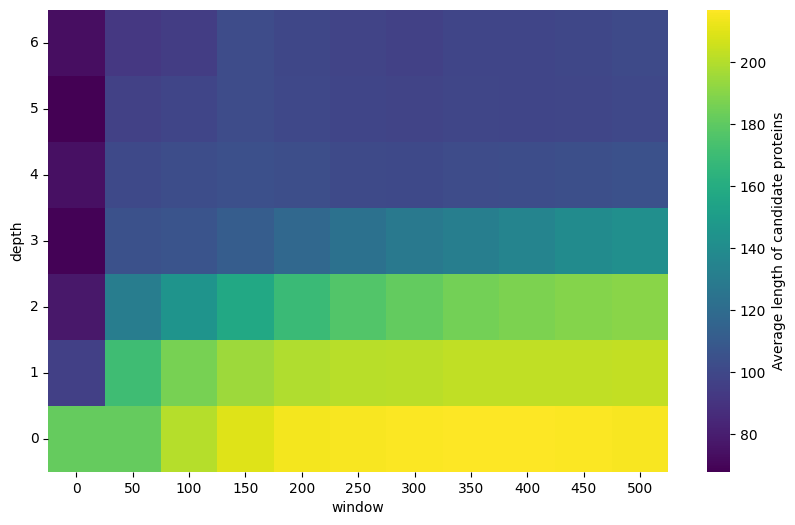

In [60]:
#plot for average length
heatmap_data2 = fi_vs_top.pivot('depth', 'window', 'avg_length')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data2, annot=False, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Average length of candidate proteins'})

plt.yticks(rotation=0)
plt.gca().invert_yaxis()
plt.title('')
plt.show()

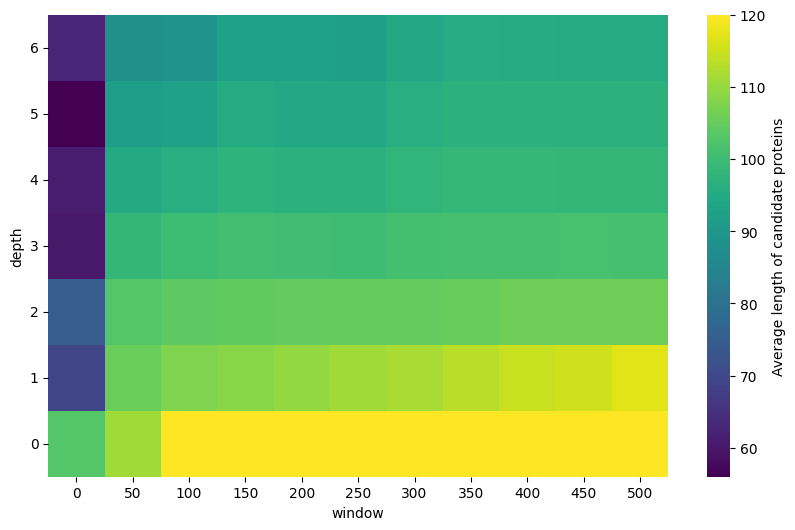

In [64]:
#plot for average length corr ided
heatmap_data3 = fi_vs_top.pivot('depth', 'window', 'avg_length_ided')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data3, annot=False, cmap='viridis',vmax = 120 ,fmt=".2f", cbar_kws={'label': 'Average length of candidate proteins'})

plt.yticks(rotation=0)
plt.gca().invert_yaxis()
plt.title('')
plt.show()

In [25]:
top[" Protein"] = top["Protein accession"].apply(lambda x: extract_core_ID(x))

In [5]:
top[" Protein"]

0       sp|P0A705|
1       sp|P0A705|
2       sp|P0A7J7|
3       sp|P45577|
4       sp|P45577|
           ...    
4929    sp|P0A9B2|
4930    sp|P0A9B2|
4931    sp|P0A9B2|
4932    sp|P0AAX3|
4933    sp|P0A9B2|
Name:  Protein, Length: 4934, dtype: object

In [27]:
fi2["Spectrum ID"] = fi2["Spectrum ID"].apply(lambda x: ((re.compile(r'[^=]+$')).search(x)).group(0))
fi2[" Protein"] = fi2[" Protein"].apply(lambda x: extract_core_ID(x))
fi2["Spectrum ID"] = fi2["Spectrum ID"].apply(lambda x: int(x))

fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: ((re.compile(r'[^=]+$')).search(x)).group(0))
fi[" Protein"] = fi[" Protein"].apply(lambda x: extract_core_ID(x))
fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: int(x))

fi

,Spectrum ID,Protein,#peaks,#multi-peaks,Charge,Delta mass,# matched peaks
43612,10008,sp|P69783|,43,7,1,-52.062500,3
43613,10008,sp|P69783|,43,7,1,78.978500,3
43614,10008,sp|P0ABW5|,43,7,1,-275.455000,2
43615,10009,sp|P69783|,52,8,1,-52.062500,3
43617,10009,sp|P0ABW5|,52,8,1,-275.455000,2
...,...,...,...,...,...,...,...
43603,9989,sp|P0ABK5|,100,30,1,-132.035000,4
43602,9989,sp|P77622|,100,30,1,-262.898000,4
43601,9989,sp|P77858|,100,30,1,-0.386719,5
43605,9989,sp|P77156|,100,30,1,-1.089840,3


*Transform the SpectrumID column*

In [28]:
merged = fi.merge(top, on = [" Protein", "Spectrum ID"], how = "inner").drop_duplicates(subset=["Spectrum ID"])
merged2 = fi2.merge(top, on = [" Protein", "Spectrum ID"], how = "inner").drop_duplicates(subset=["Spectrum ID"])

In [29]:
merged2


,Spectrum ID,Protein,#peaks,#multi-peaks,Charge,Delta mass,# matched peaks,Data file name,Prsm ID,Fragmentation,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,10006,sp|P0ACX3|,31,4,1,158.04000,4,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4306,HCD,...,1,+159.0323:[1-2],0,NaN,-,30,29,7.081240e-18,0.0,0.0
3,10008,sp|P69783|,43,10,1,78.97850,8,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4307,HCD,...,1,+80.3446:[34-121],0,NaN,-,17,17,1.262537e-09,0.0,0.0
5,10009,sp|P69783|,52,13,1,-52.06250,10,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4308,HCD,...,1,+80.1296:[48],0,NaN,-,21,21,3.182790e-10,0.0,0.0
7,10010,sp|P69783|,64,23,1,78.97850,12,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4309,HCD,...,1,+80.3446:[34-124],0,NaN,-,25,25,2.399525e-16,0.0,0.0
9,10024,sp|P0AEG4|,32,8,1,-3.01562,7,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4314,HCD,...,1,-0.9775:[28-101],0,NaN,-,28,28,2.221769e-19,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,9965,sp|P0ABK5|,82,10,1,-132.02000,2,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4297,HCD,...,0,NaN,0,NaN,-,16,13,1.999960e-06,0.0,0.0
11304,9979,sp|P69783|,73,26,1,-52.08400,14,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4299,HCD,...,1,+80.3239:[31-124],0,NaN,-,24,24,1.260351e-14,0.0,0.0
11306,9986,sp|P69783|,31,10,1,-52.05860,9,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4300,HCD,...,1,+80.3486:[37-168],0,NaN,-,13,13,3.143676e-09,0.0,0.0
11308,9988,sp|P0ABK5|,92,21,1,-132.01200,5,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4301,HCD,...,0,NaN,0,NaN,-,13,11,1.455840e-03,0.0,0.0


In [30]:
df1_values_not_in_df2 = top[~top['Spectrum ID'].isin(merged2['Spectrum ID'])]

In [31]:
df1_values_not_in_df2

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value,Protein
6,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,6,1039,HCD,1039,488.95,39,4,3224.605313,3224.602160,...,NaN,0,NaN,-,15,15,6.842850e-11,0.000000,0.000000,sp|P69428|
11,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,11,1060,HCD,1060,498.86,15,5,3396.686913,3396.686952,...,NaN,0,NaN,-,5,5,7.782400e-06,0.000000,0.000000,sp|P69428|
29,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,29,1103,HCD,1103,520.18,39,4,2623.402750,2624.405100,...,+14.9802:[2],0,NaN,-,10,10,4.744413e-06,0.000000,0.000000,sp|P68191|
33,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,33,1153,HCD,1153,541.67,18,4,2849.528447,2849.526708,...,NaN,0,NaN,-,6,6,1.461928e-05,0.000000,0.000000,sp|P0A7M2|
37,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,37,1182,HCD,1182,555.31,30,5,3121.562542,3121.557459,...,NaN,0,NaN,-,5,5,5.172551e-02,0.002149,0.005931,sp|A0A385XJE6|
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4929,14349,HCD,14349,5356.50,116,8,6581.523144,6581.653144,...,-472.9807:[35-63],0,NaN,-,9,9,2.018585e-01,0.007391,0.019597,sp|P0A9B2|
4930,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4930,14414,HCD,14414,5374.91,47,6,4514.082071,4514.172071,...,+197.7963:[34-39],0,NaN,-,6,6,3.703517e-02,0.001738,0.004846,sp|P0A9B2|
4931,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4931,14432,HCD,14432,5378.94,103,7,6525.282912,6525.412912,...,-335.1405:[36-60],0,NaN,-,8,8,1.618212e-02,0.000673,0.001908,sp|P0A9B2|
4932,C:/Users/KyowonJeong/Dropbox/tmp/Eclip_1476_MB...,4932,14439,HCD,14439,5380.29,135,9,8579.713403,8580.745753,...,-23.6624:[50],0,NaN,-,6,6,6.937670e-02,0.002765,0.007580,sp|P0AAX3|
